#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [ ]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [ ]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
data['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [ ]:
data['Activity'].value_counts() / data.shape[0]

LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64

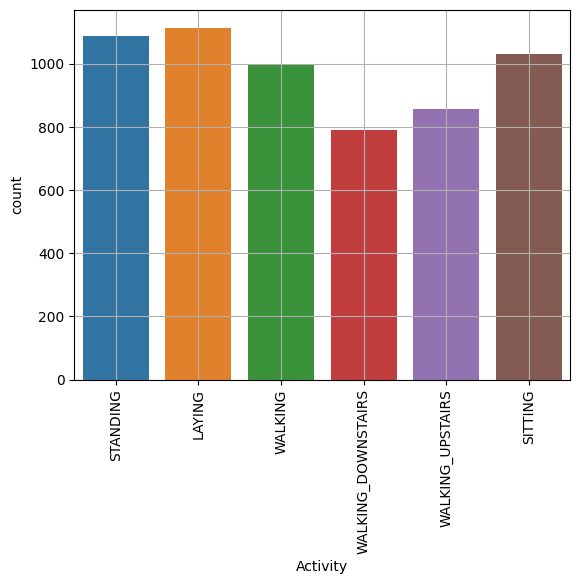

In [ ]:
sns.countplot(x = 'Activity', data = data)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
features['sensor'].value_counts()

fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: sensor, dtype: int64

In [ ]:
#센서 그룹 데이터의 'agg'변수의 값 확인
features['agg'].value_counts()

bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: agg, dtype: int64

In [ ]:
#센서 그룹 데이터의 'axis'변수의 값 확인
features['axis'].value_counts()

X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: axis, Length: 62, dtype: int64

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
# 데이터 분할을 위한 전처리
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3)

#### 2) 모델링

In [ ]:
#생성
model = RandomForestClassifier()

#학습
model.fit(x_train, y_train)
pred = model.predict(x_val)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.9756373937677054
[[332   0   0   0   0   0]
 [  0 318  15   0   0   0]
 [  0  15 303   0   0   0]
 [  0   0   0 295   2   2]
 [  0   0   0   3 240   2]
 [  0   0   0   2   2 234]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       332
           SITTING       0.95      0.95      0.95       333
          STANDING       0.95      0.95      0.95       318
           WALKING       0.98      0.99      0.98       299
WALKING_DOWNSTAIRS       0.98      0.98      0.98       245
  WALKING_UPSTAIRS       0.98      0.98      0.98       238

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,tGravityAcc-max()-X,0.032312
1,tGravityAcc-energy()-X,0.031068
2,tGravityAcc-min()-Y,0.029147
3,tGravityAcc-mean()-X,0.028567
4,"angle(Y,gravityMean)",0.026658
...,...,...
556,"fBodyAcc-bandsEnergy()-49,64.2",0.000088
557,fBodyAcc-entropy()-Y,0.000087
558,"fBodyAcc-bandsEnergy()-25,48.1",0.000080
559,fBodyAcc-min()-X,0.000074


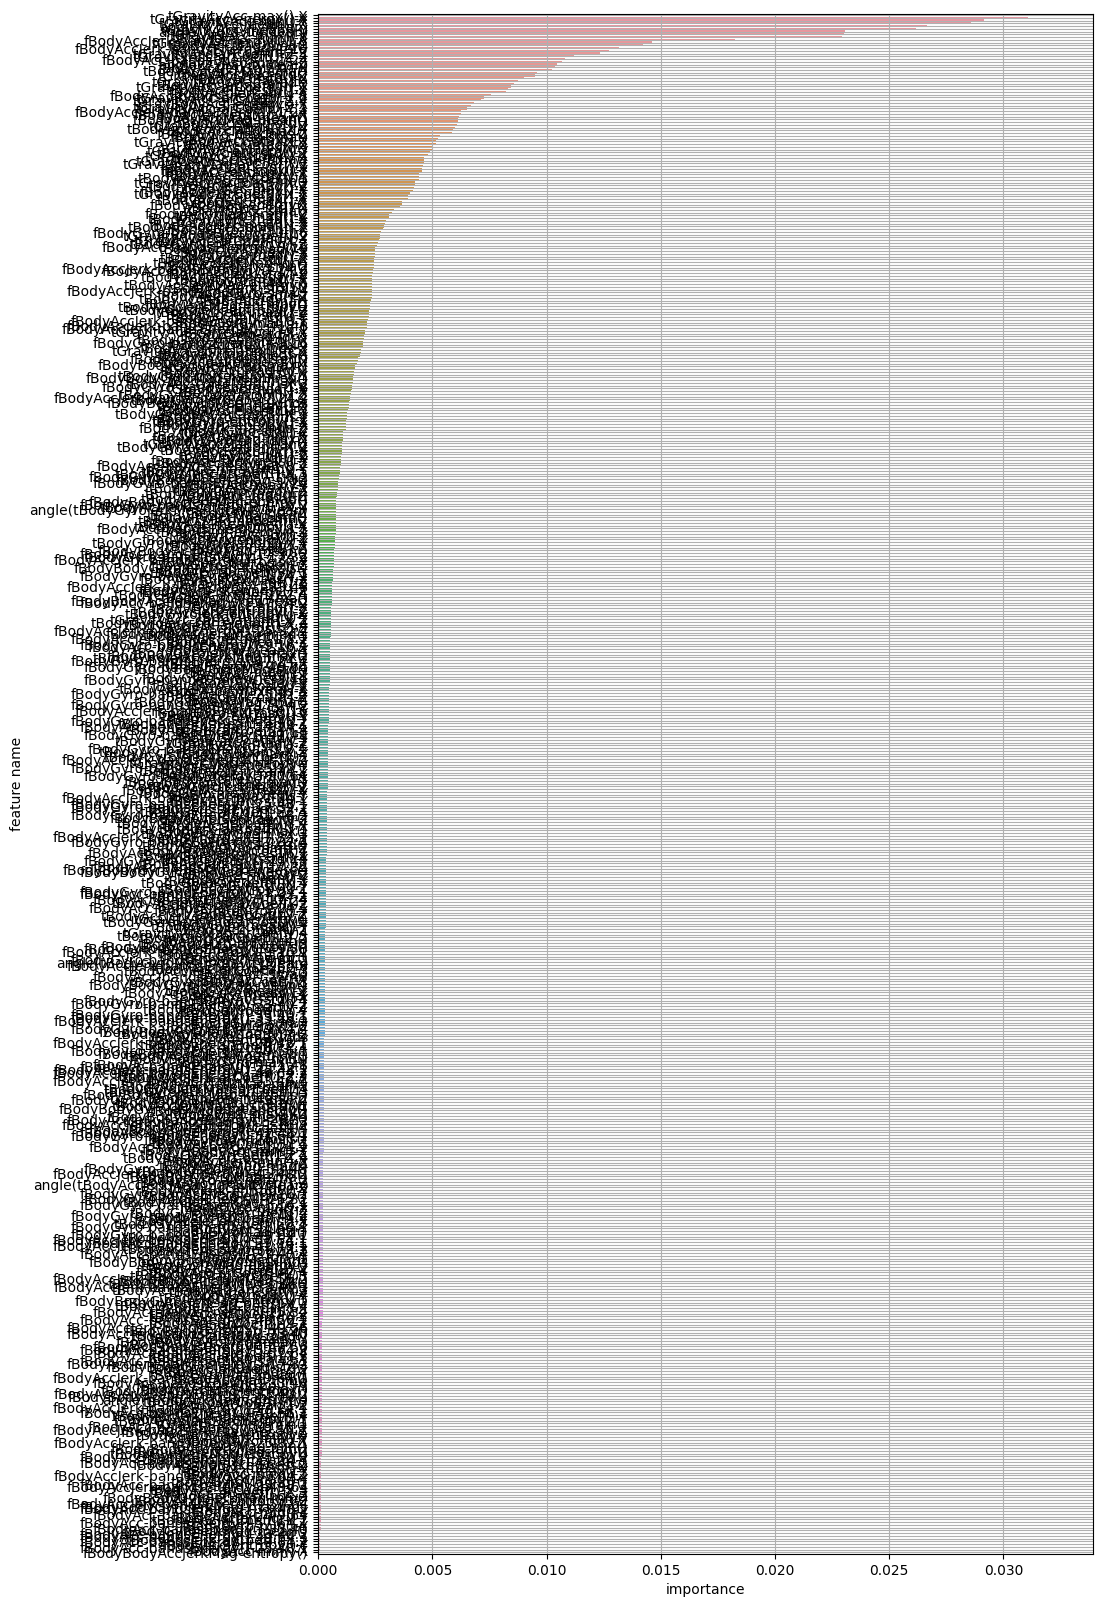

In [ ]:
# 변수 중요도 추출
r0 = plot_feature_importance(model.feature_importances_, list(x_train), False)
r0

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 top 5
r0.head(5)

,feature_name,feature_importance
0,tGravityAcc-max()-X,0.032312
1,tGravityAcc-energy()-X,0.031068
2,tGravityAcc-min()-Y,0.029147
3,tGravityAcc-mean()-X,0.028567
4,"angle(Y,gravityMean)",0.026658


In [ ]:
# 중요도 하위 top 5
r0.tail(5)

,feature_name,feature_importance
556,"fBodyAcc-bandsEnergy()-49,64.2",0.000088
557,fBodyAcc-entropy()-Y,0.000087
558,"fBodyAcc-bandsEnergy()-25,48.1",0.000080
559,fBodyAcc-min()-X,0.000074
560,fBodyBodyAccJerkMag-entropy(),0.000023


#### 2) 상위 5개 변수에 대한 분석

<Axes: xlabel='tGravityAcc-mean()-X', ylabel='Density'>

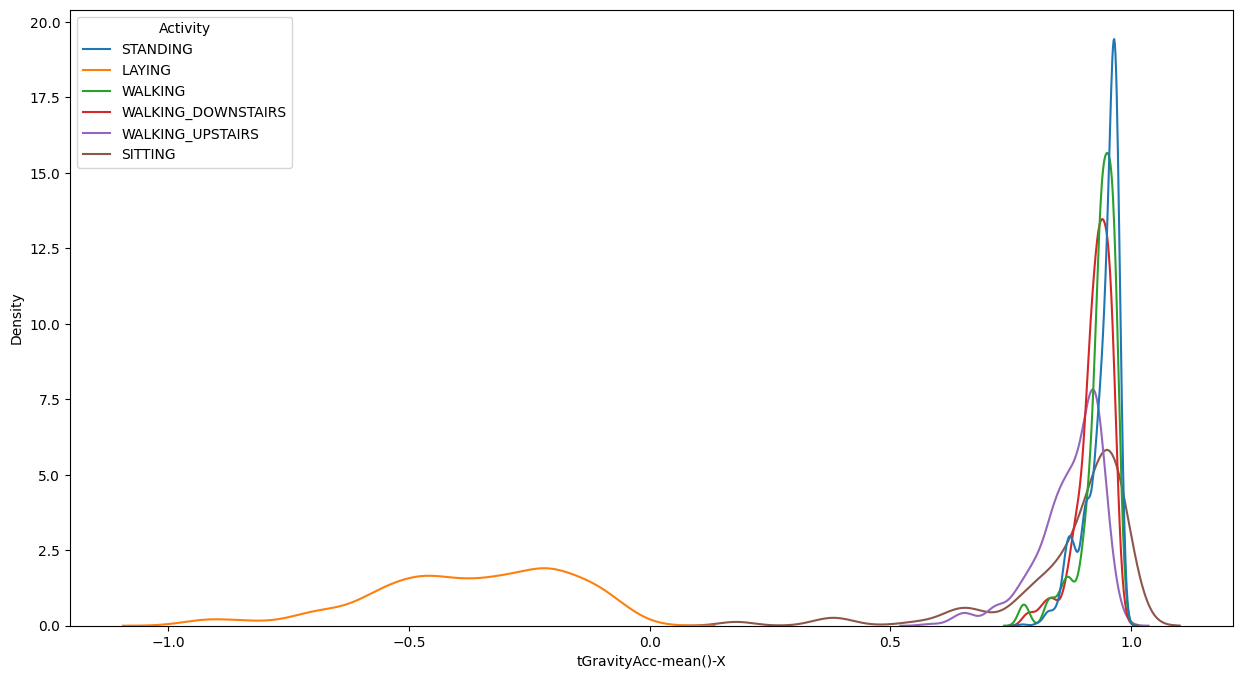

In [ ]:
# 1위 : tGravityAcc-mean()-X
var = 'tGravityAcc-mean()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='angle(Y,gravityMean)', ylabel='Density'>

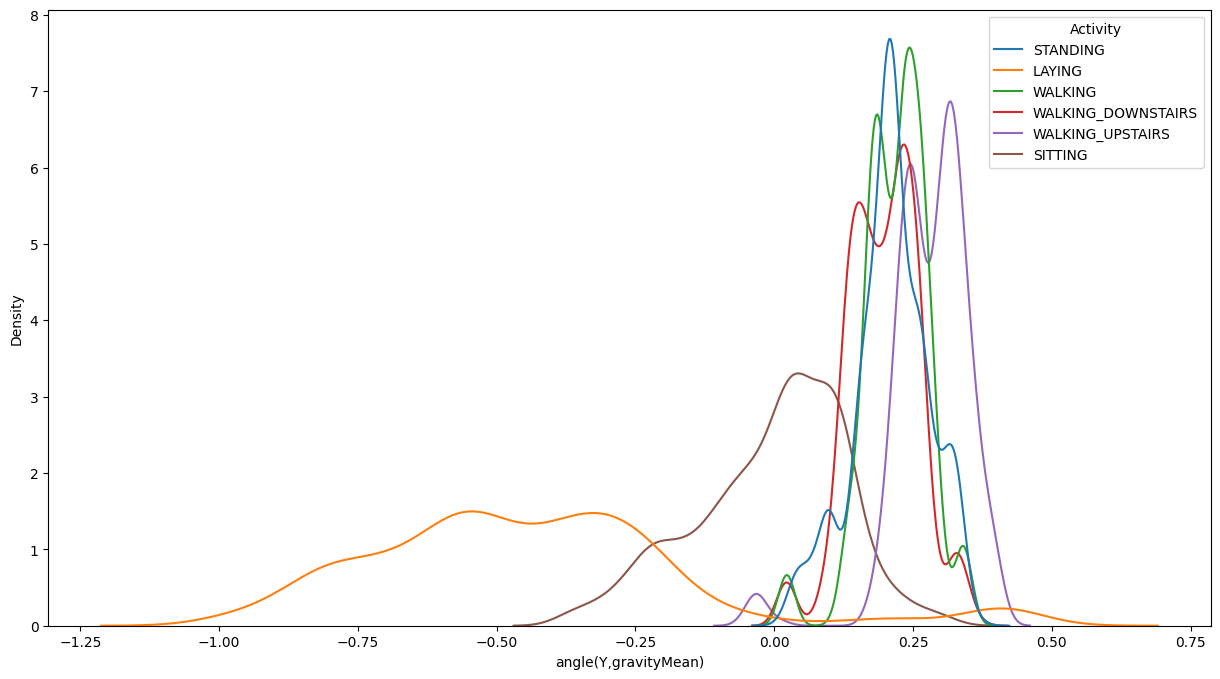

In [ ]:
# 2위 : angle(Y,gravityMean)
var = 'angle(Y,gravityMean)'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='tGravityAcc-energy()-X', ylabel='Density'>

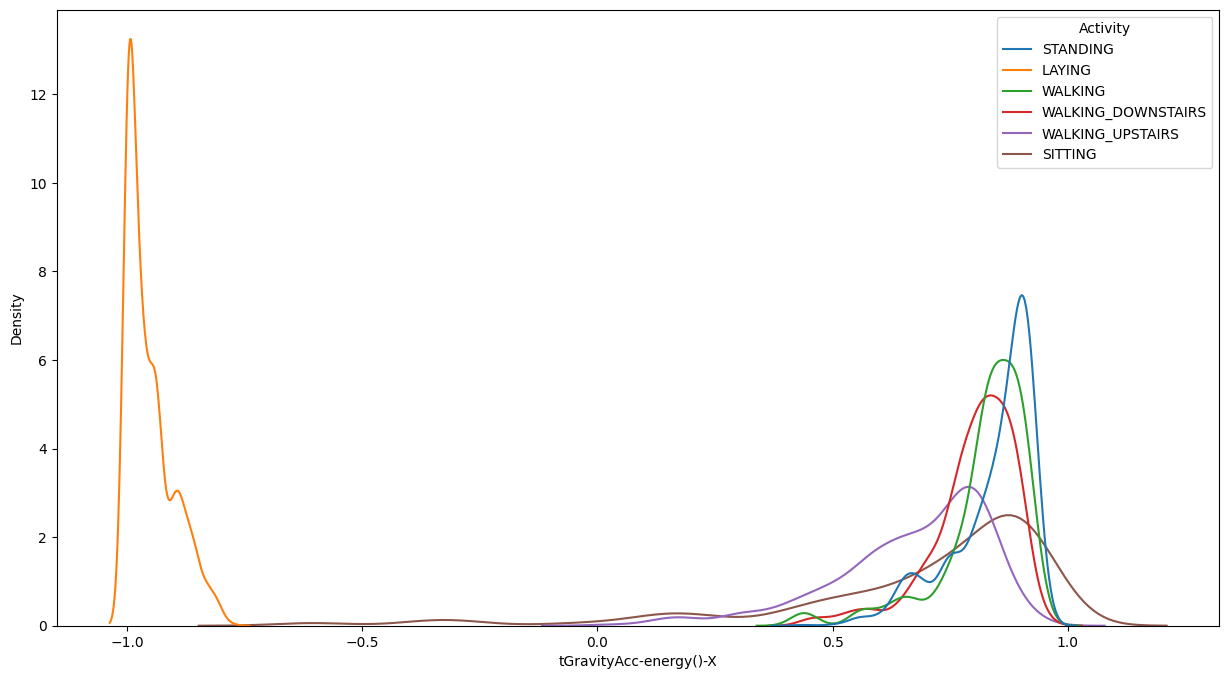

In [ ]:
# 3위 : tGravityAcc-energy()-X
var = 'tGravityAcc-energy()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='tGravityAcc-max()-X', ylabel='Density'>

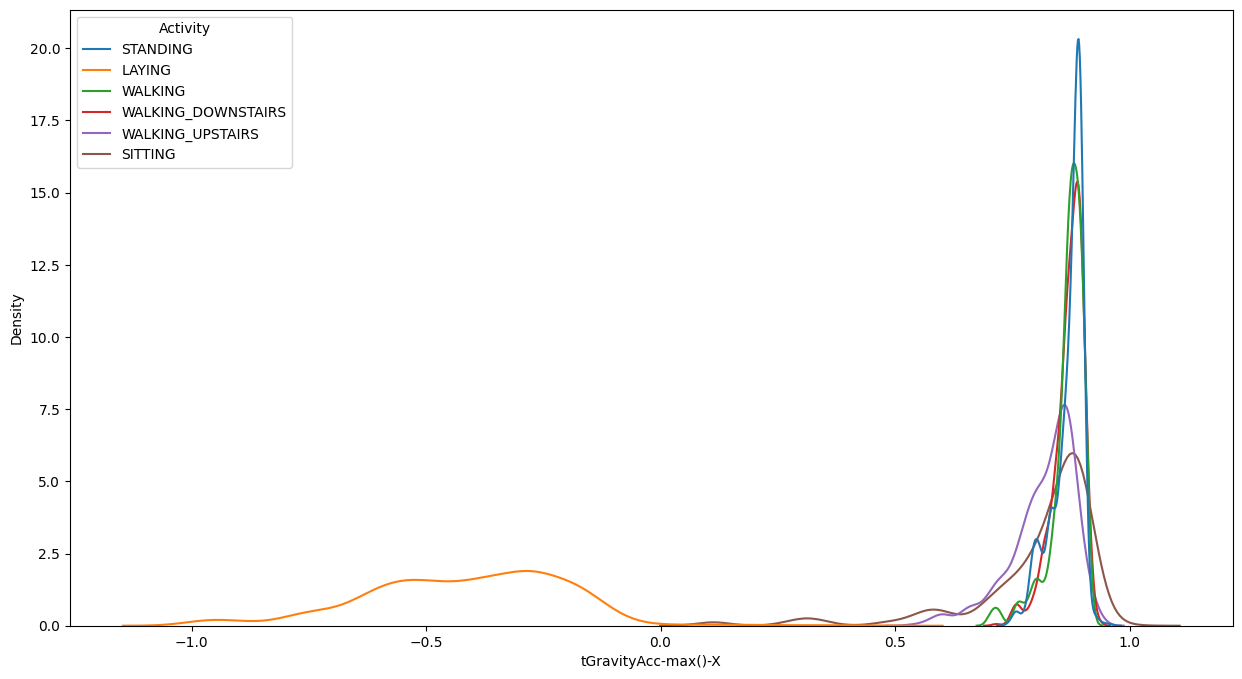

In [ ]:
# 4위 : tGravityAcc-max()-X
var = 'tGravityAcc-max()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='tGravityAcc-min()-X', ylabel='Density'>

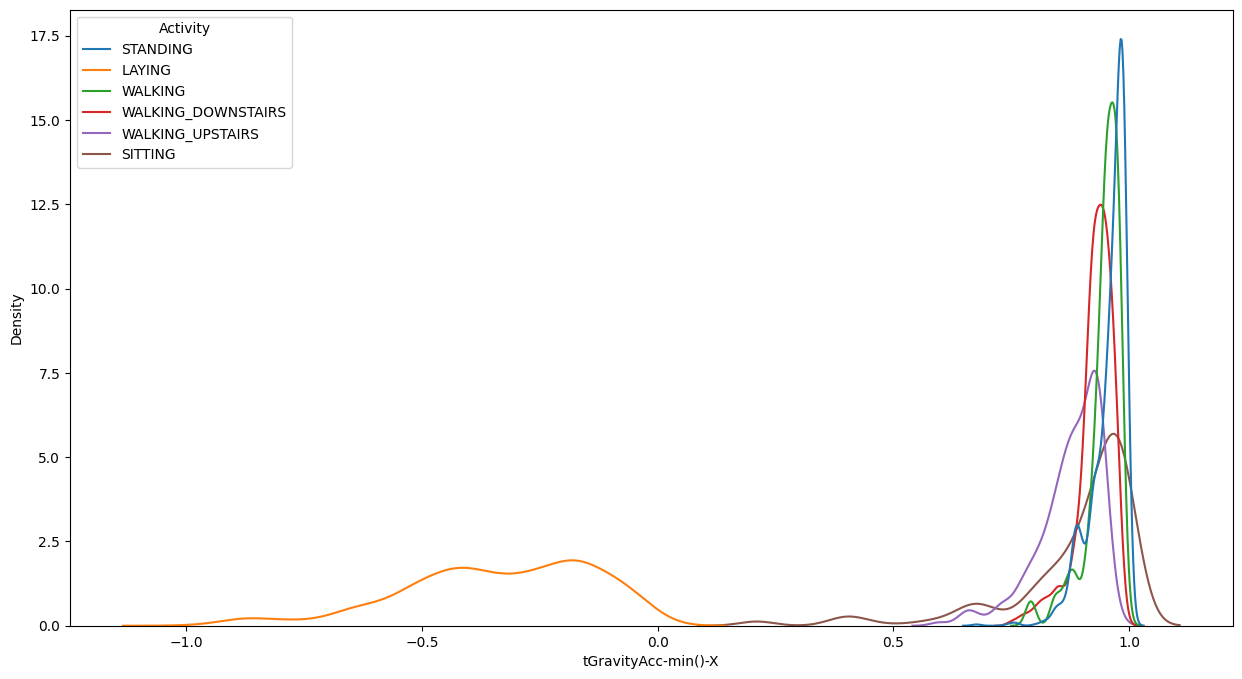

In [ ]:
# 5위 : tGravityAcc-min()-X
var = 'tGravityAcc-min()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

#### 3) 하위 5개 변수에 대한 분석

<Axes: xlabel='fBodyBodyAccJerkMag-maxInds', ylabel='Density'>

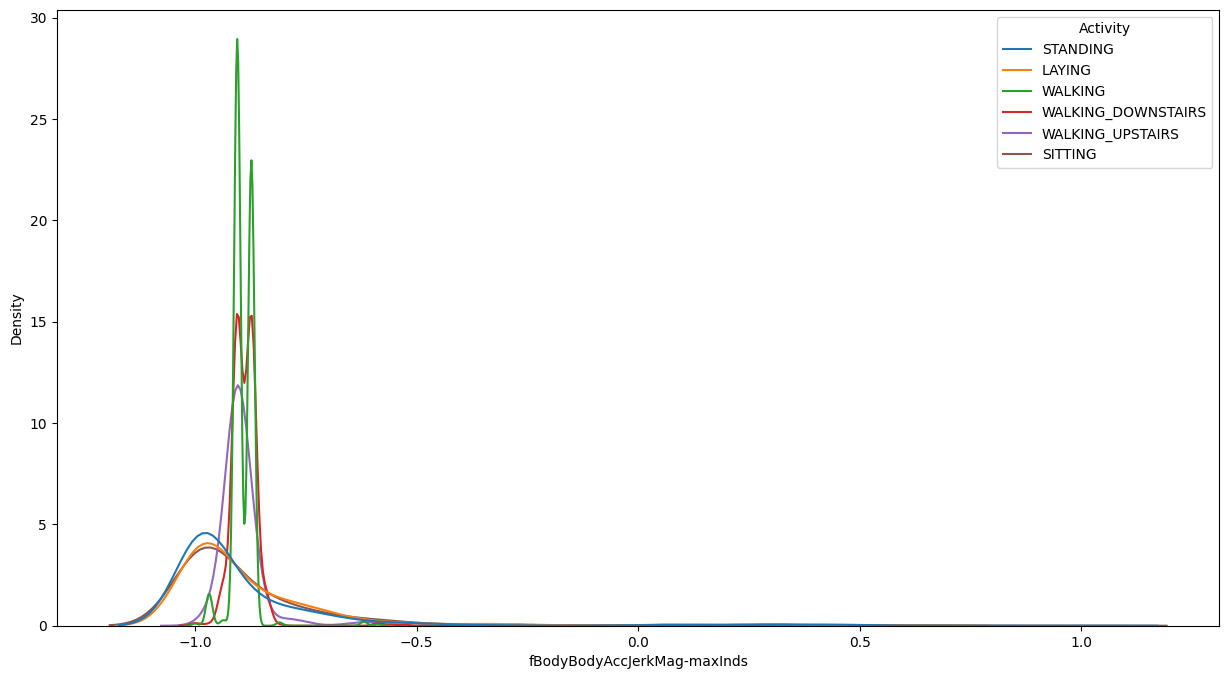

In [ ]:
# 1위 : fBodyBodyAccJerkMag-maxInds
var = 'fBodyBodyAccJerkMag-maxInds'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='fBodyBodyAccJerkMag-entropy()', ylabel='Density'>

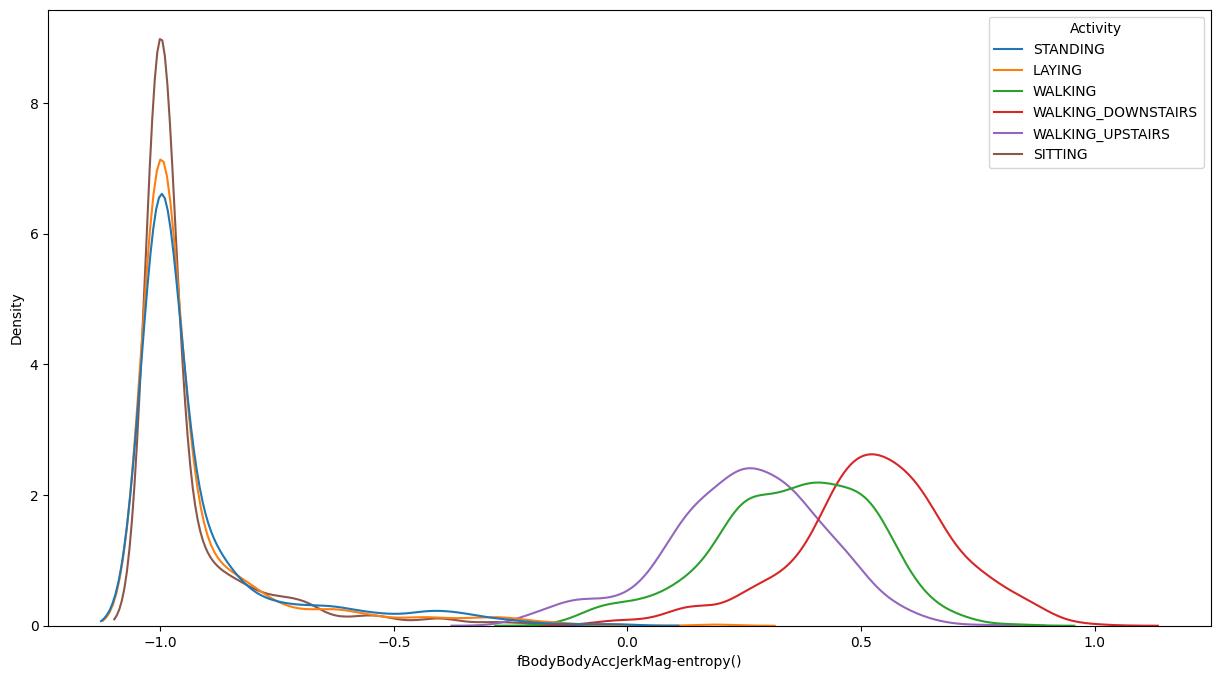

In [ ]:
# 2위 : fBodyBodyAccJerkMag-entropy()
var = 'fBodyBodyAccJerkMag-entropy()'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='fBodyGyro-bandsEnergy()-57,64.1', ylabel='Density'>

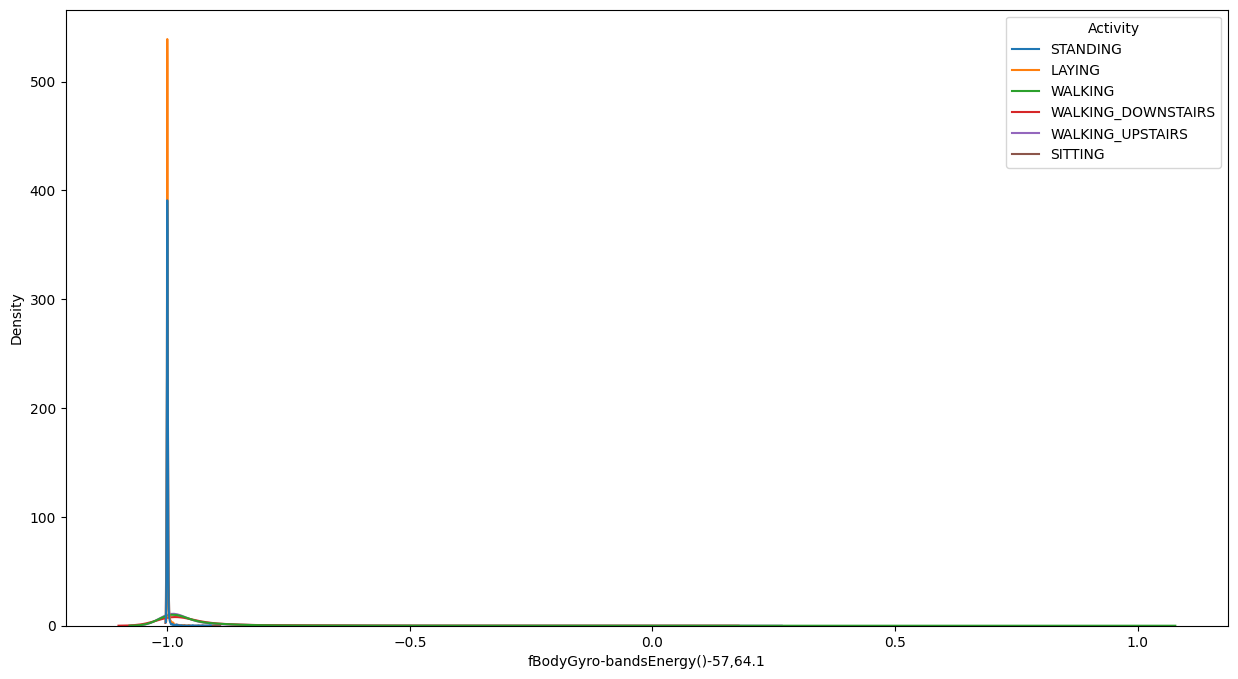

In [ ]:
# 3위 : fBodyGyro-bandsEnergy()-57,64.1
var = 'fBodyGyro-bandsEnergy()-57,64.1'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='fBodyBodyAccJerkMag-entropy()', ylabel='Density'>

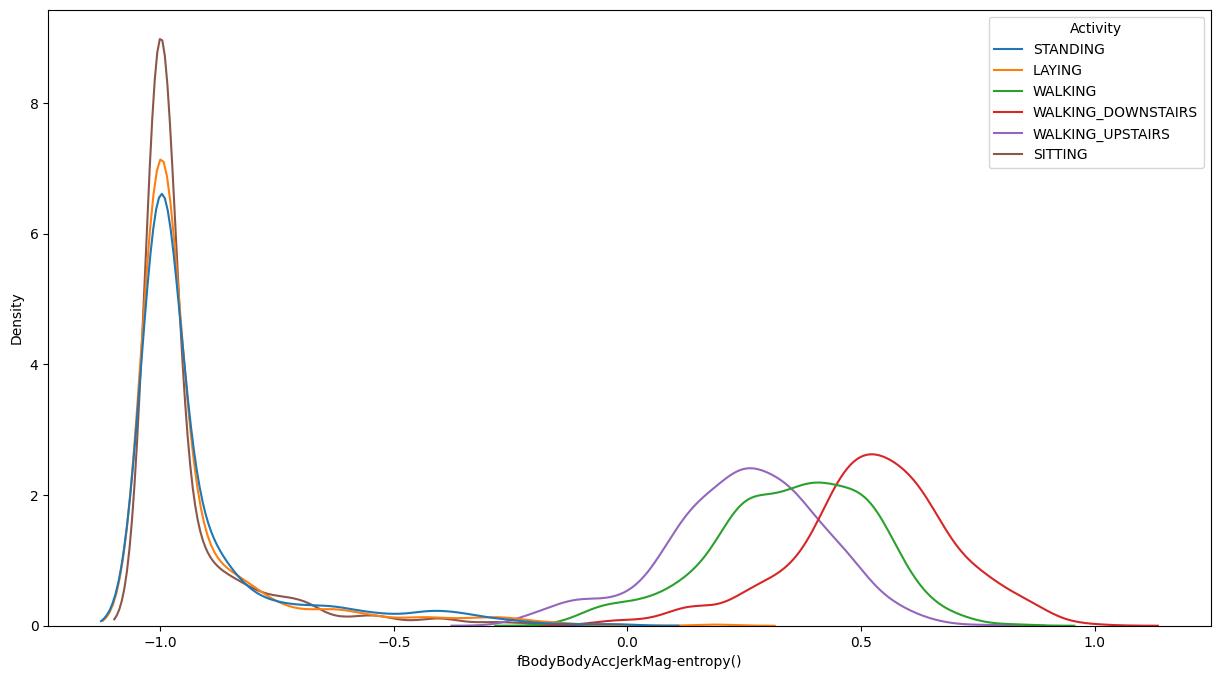

In [ ]:
# 4위 : fBodyBodyAccJerkMag-entropy()
var = 'fBodyBodyAccJerkMag-entropy()'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

<Axes: xlabel='fBodyBodyAccJerkMag-maxInds', ylabel='Density'>

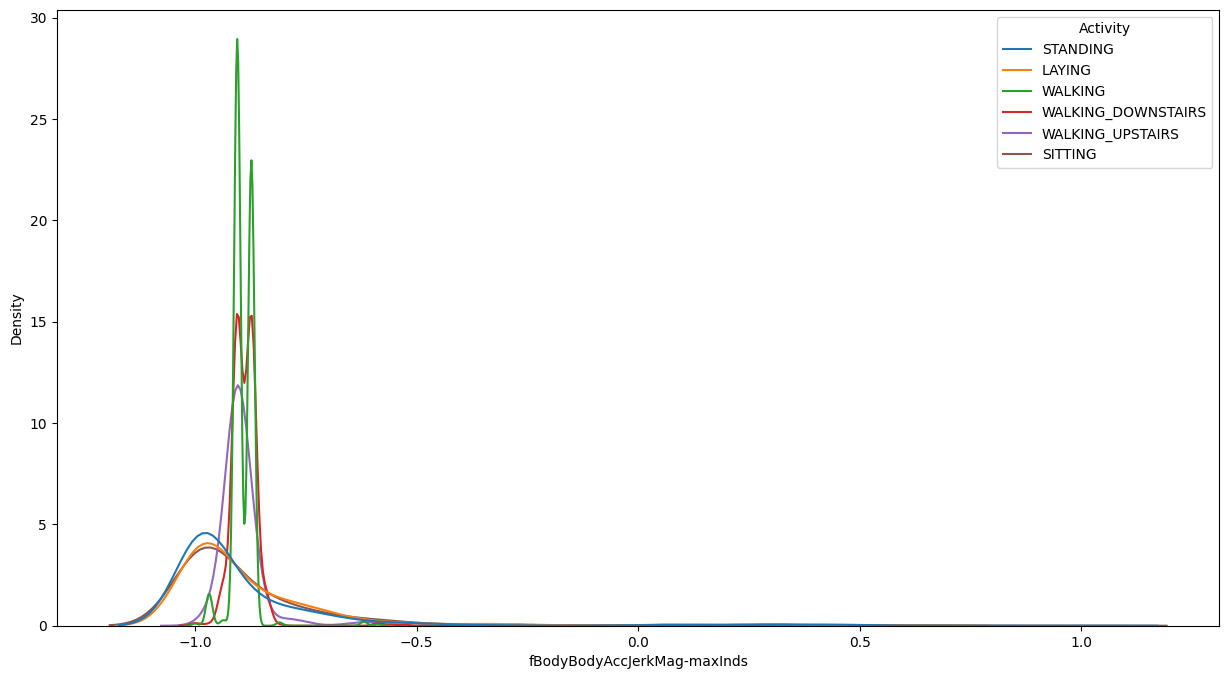

In [ ]:
# 5위 : fBodyBodyAccJerkMag-maxInds
var = 'fBodyBodyAccJerkMag-maxInds'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = data, hue =target, common_norm = False)

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
is_dynamic = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
is_dynamic

0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: Activity, Length: 5881, dtype: int64

#### 2) 기본모델 생성

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, is_dynamic, test_size = .3)

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.9988668555240793
[[970   2]
 [  0 793]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       972
           1       1.00      1.00      1.00       793

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,fBodyAccJerk-max()-X,0.070098
1,"fBodyAccJerk-bandsEnergy()-1,8",0.050146
2,tBodyAccJerk-mad()-X,0.050078
3,"fBodyAccJerk-bandsEnergy()-1,16",0.040156
4,tBodyAccJerk-iqr()-Y,0.039971
...,...,...
556,tBodyAccMag-min(),0.000000
557,tBodyAccMag-max(),0.000000
558,tBodyAccMag-mad(),0.000000
559,tBodyAccMag-std(),0.000000


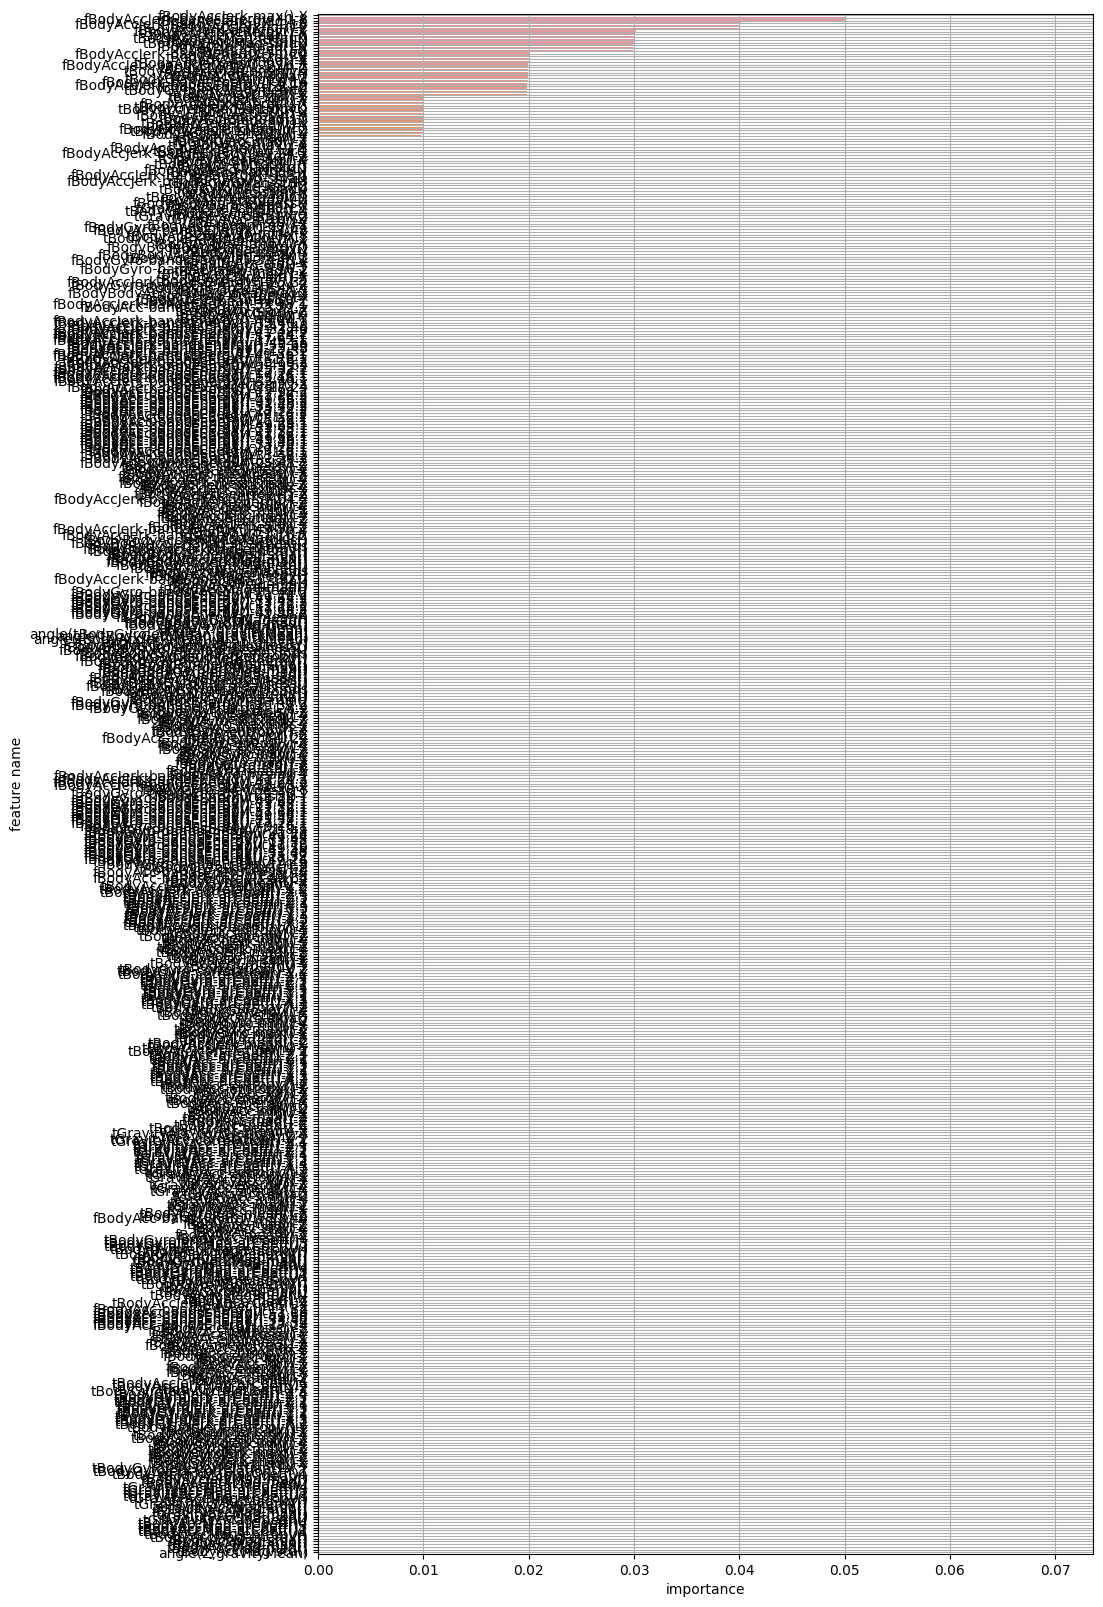

In [ ]:
r_dyn = plot_feature_importance(model.feature_importances_, list(x_train), False)
r_dyn

* 상위 변수 선정

In [ ]:
r_dyn.head()


,feature_name,feature_importance
0,fBodyAccJerk-max()-X,0.070098
1,"fBodyAccJerk-bandsEnergy()-1,8",0.050146
2,tBodyAccJerk-mad()-X,0.050078
3,"fBodyAccJerk-bandsEnergy()-1,16",0.040156
4,tBodyAccJerk-iqr()-Y,0.039971


* 데이터 탐색하기

In [ ]:
temp = x.copy()
temp['is_dynamic'] = is_dynamic
target = 'is_dynamic'

<Axes: xlabel='tBodyAccJerk-entropy()-X', ylabel='Density'>

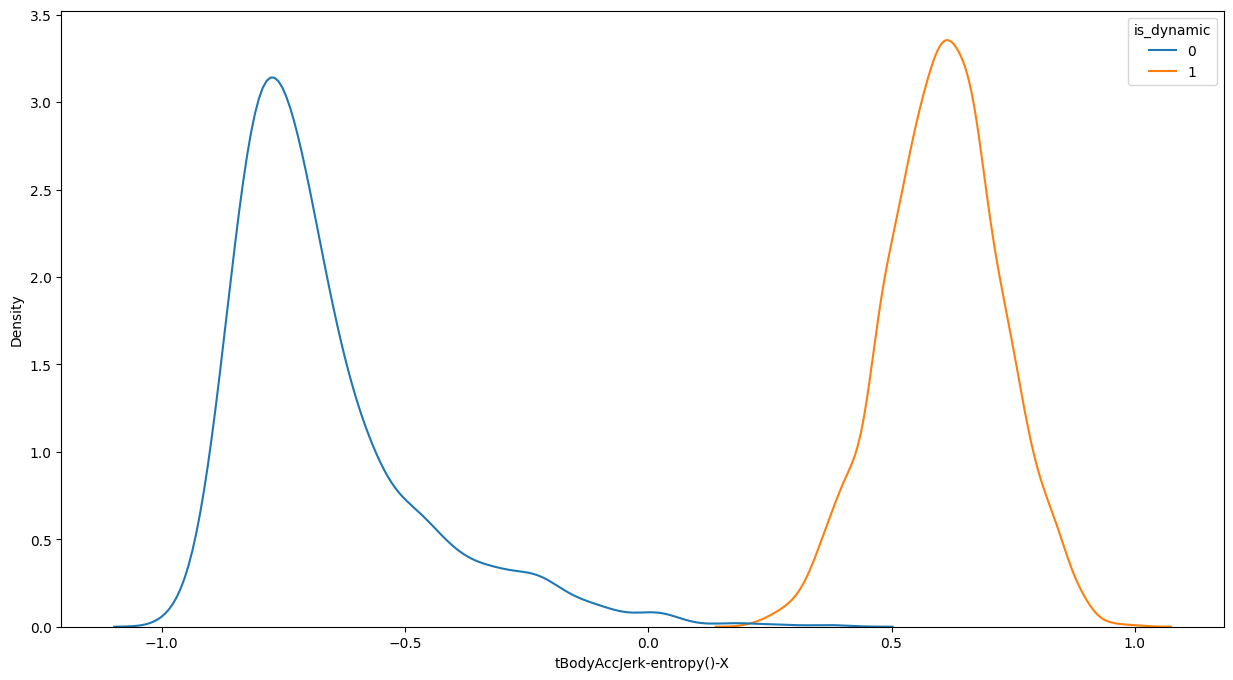

In [ ]:
# 1위 : tBodyAccJerk-entropy()-X
var = 'tBodyAccJerk-entropy()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = temp, hue =target, common_norm = False)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,16', ylabel='Density'>

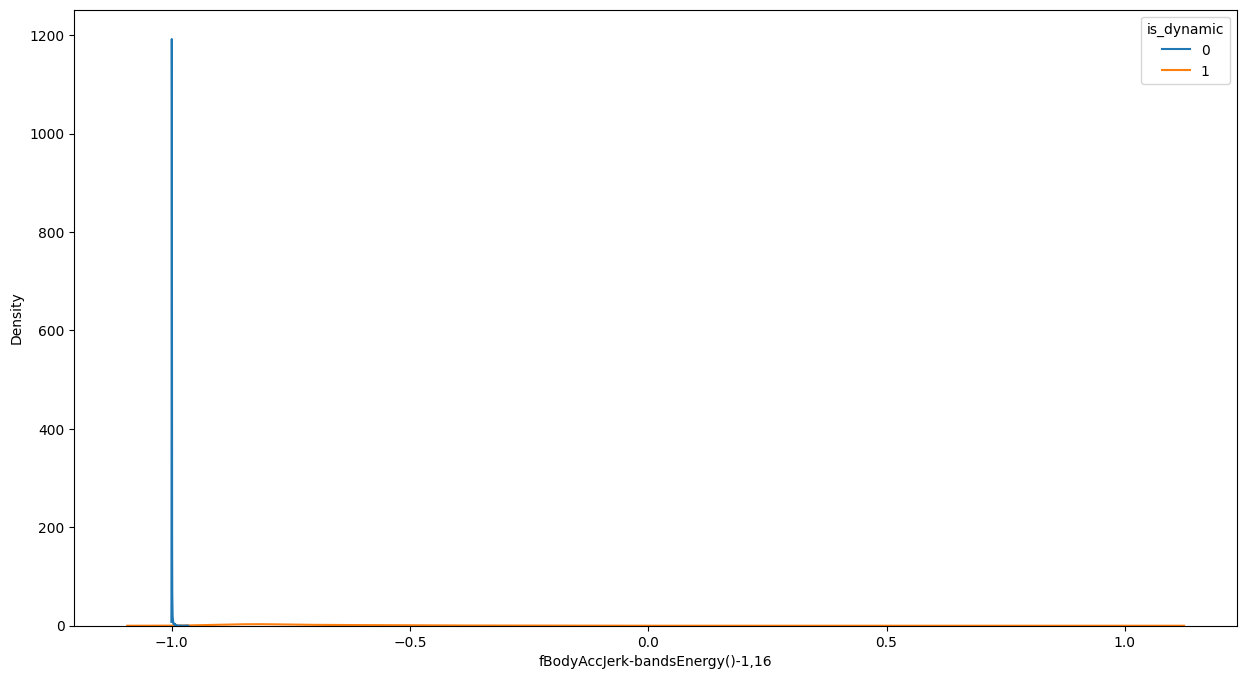

In [ ]:
# 2위 : fBodyAccJerk-bandsEnergy()-1,16
var = 'fBodyAccJerk-bandsEnergy()-1,16'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = temp, hue =target, common_norm = False)

<Axes: xlabel='fBodyAccJerk-max()-X', ylabel='Density'>

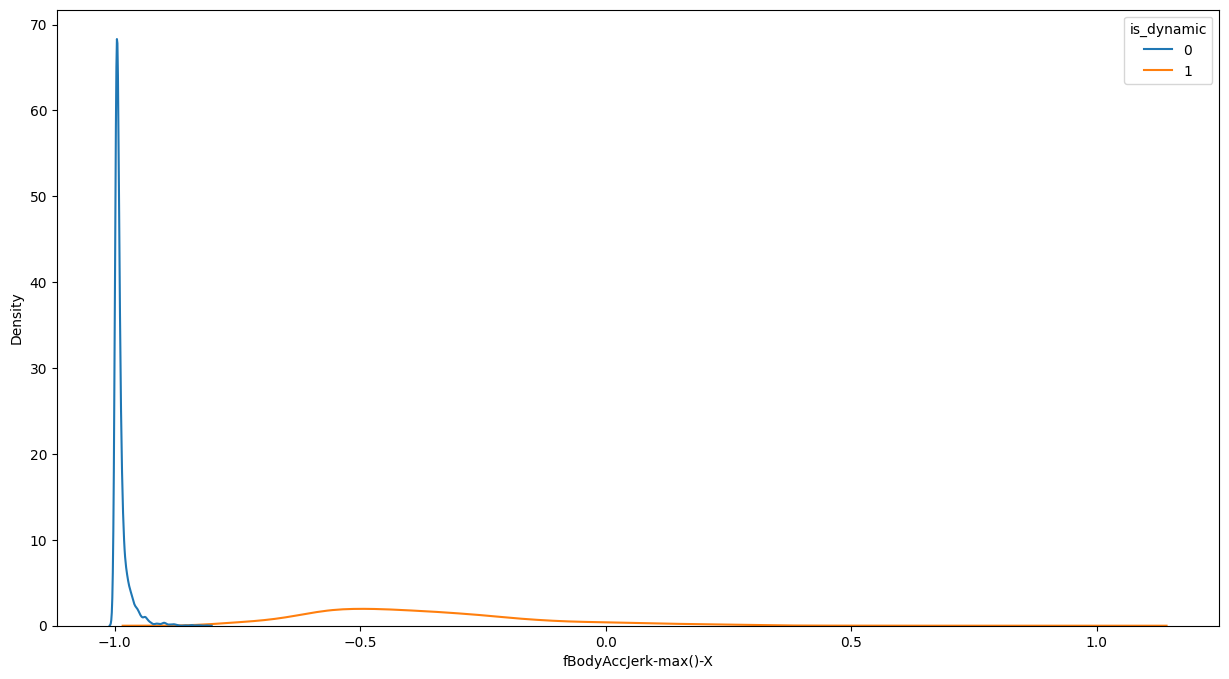

In [ ]:
# 3위 : fBodyAccJerk-max()-X
var = 'fBodyAccJerk-max()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = temp, hue =target, common_norm = False)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,24', ylabel='Density'>

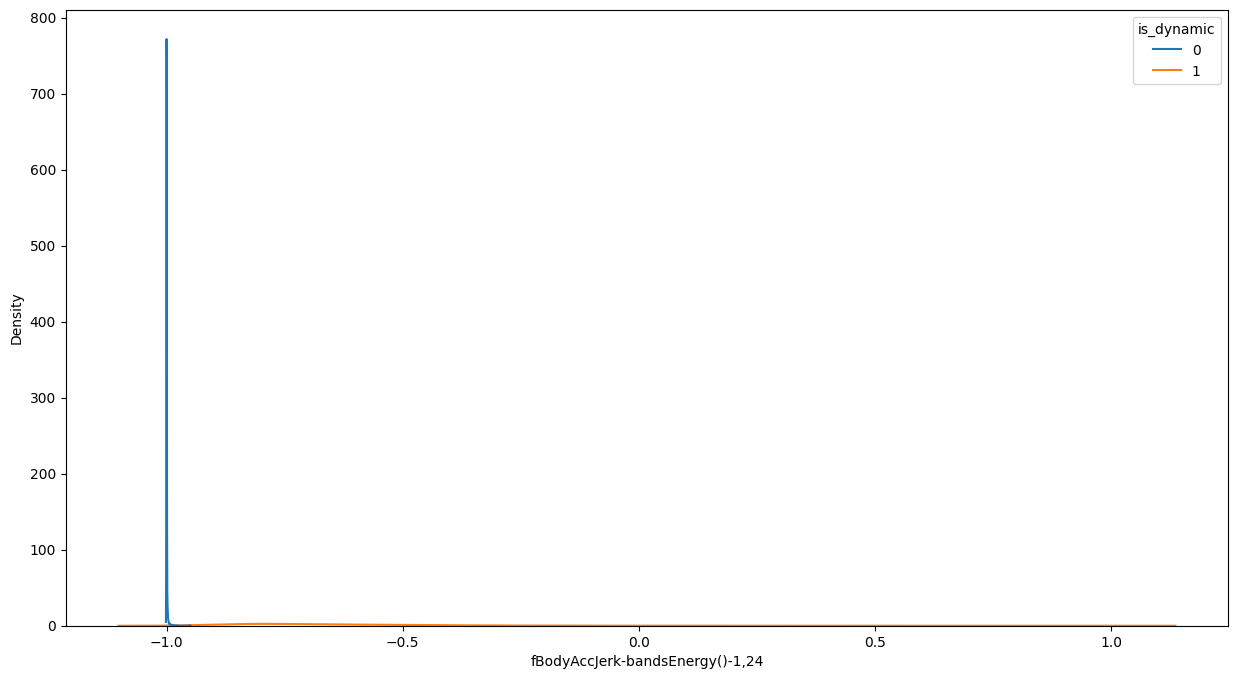

In [ ]:
# 4위 : fBodyAccJerk-bandsEnergy()-1,24
var = 'fBodyAccJerk-bandsEnergy()-1,24'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = temp, hue =target, common_norm = False)

<Axes: xlabel='tBodyAccJerk-iqr()-X', ylabel='Density'>

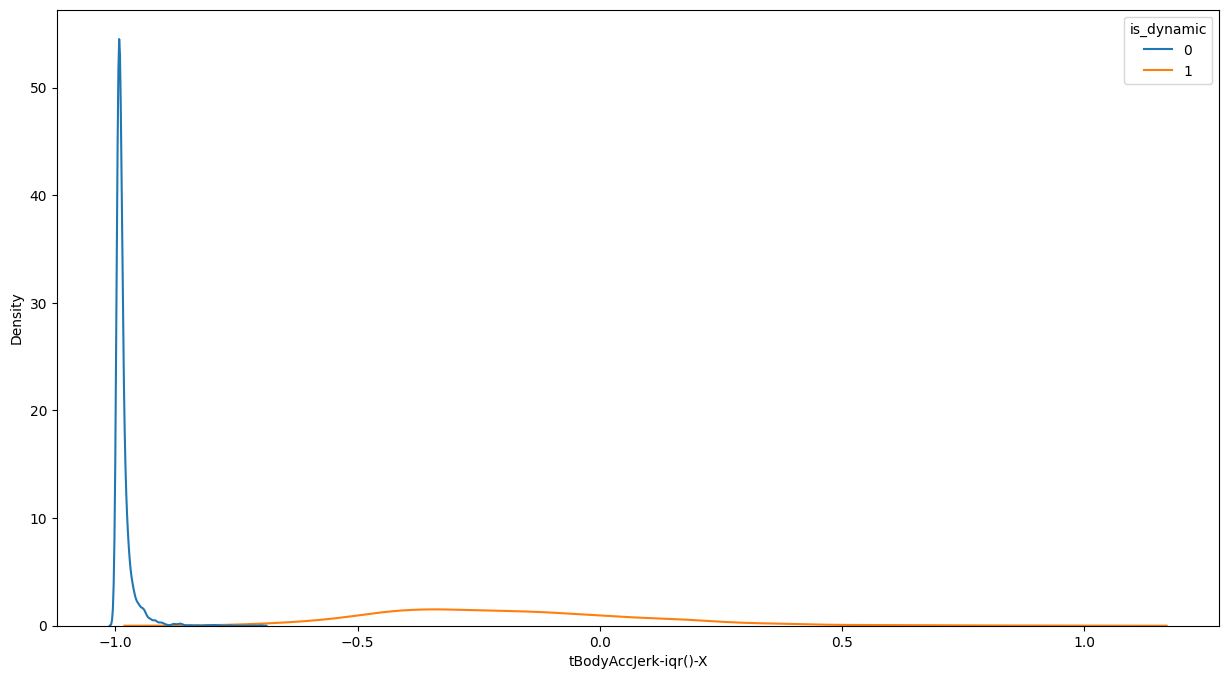

In [ ]:
# 5위 : tBodyAccJerk-iqr()-X
var = 'tBodyAccJerk-iqr()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = temp, hue =target, common_norm = False)

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
r0.rename(columns={'feature_importance':'fi_all'}, inplace=True)
r_dyn.rename(columns={'feature_importance':'fi_dynamic'}, inplace=True)

#### 2) 합치기

In [ ]:
result = pd.merge(features, r0)
result = pd.merge(result, r_dyn)
result.head()

,sensor,agg,axis,feature_name,fi_all,fi_dynamic
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000303,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000355,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000165,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.008991,0.009964
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000302,0.000018


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

joblib.dump(result, path + 'fi_analysis.pkl')

['/content/drive/MyDrive/project/fi_analysis.pkl']